# Assignement E02 - DSIM

*Marco Donzella 829358* 

Implement the Zero-Crossing Rate (ZCR) feature to describe a single-channel audio signal, starting from the commands shown during the laboratory.

Rules:

1. Show the effects on classification performance for the dataset "free-spoken-digit-dataset" (recordings.tar).
2. Verify the effect of using ZCR in combination with other features available in the published notebook.
3. Using libraries such as Librosa is not allowed, as they offer pre-made functions to compute ZCR.
4. It is, instead, possible to use numpy for the basic operations (shift, sign, etc.).
5. Many variations of ZCR exist and will be accepted: whenever you make arbitrary decisions in the implementation, just describe them in the submission.

Submission:

1. Notebook with well-commented steps and observations on the results.
2. If you submit a .py script instead of a notebook, attach a short report for the observations on the results.
3. Name the submitted file as: E02_surname_name_studentID

In [ ]:
import os
import numpy as np
import pandas as pd
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Advanced audio features
import librosa
import librosa.display as lid
from sklearn.preprocessing import scale

Carichiamo il dataset di interesse collegando il notebook all'account drive.

In [ ]:
drive.mount('/content/gdrive') # i file sono solo visibili

Mounted at /content/gdrive


In [ ]:
copyfile('gdrive/MyDrive/Digital Signal and Image Management/lezione 2/recordings.tar','recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close() # i file sono stati estratti

## Data loader

- Il dataset viene caricato
- Viene estratta la classe specificata nel nome del file
- Le tracce audio vengono divise in training set e test set
- I dati vengono normalizzati 

In [ ]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize: # è una standardizzazione
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

# Main
if __name__ == '__main__':
	X_train, X_test, y_train, y_test = load_data()


## ZCR

Viene definita la funzione zcr2 per calcolare il zero crossing rate di un segnale audio. Tale funzione è stata definita supponendo che il segnale audio fosse ciclico e dunque si ripetesse (in questo modo il primo valore del segnale audio originale occuperà l'ultima posizione nel segnale audio traslato).

*È riportato di seguito un link con un approfondimento della zero crossing rate e della relativa formula sotto implementata:
https://www.sciencedirect.com/topics/engineering/zero-crossing-rate#:~:text=The%20ZCR%20is%20defined%20according,xi(n)%3C0.*

In [ ]:
def zcr2(input):
  sign = np.sign(input) # segno dell'input originale
  sign_t = np.sign(np.roll(input,-1)) # segno dell'input traslato di 1 (il primo valore dell'input originale occupa dunque l'ultima posizione)
  value = 1/(2*len(input)) * np.sum(abs(sign - sign_t), keepdims=True) # valore di zcr
  return value

## SVM - primo approccio

In questa prima fase viene utilizzata solo la feature definita prima per estrarre i dati.

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=zcr2)

Si procede dunque addestrando il classificatore SVM:

In [ ]:
clf = SVC(kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test) # y cappuccio

In [ ]:
print(classification_report(y_test, y_pred)) # performance del classificatore

              precision    recall  f1-score   support

           0       0.29      0.71      0.41        17
           1       0.00      0.00      0.00        10
           2       0.29      0.13      0.18        15
           3       0.00      0.00      0.00        19
           4       0.17      0.64      0.27        11
           5       0.19      0.50      0.28        14
           6       0.92      0.79      0.85        14
           7       0.00      0.00      0.00        19
           8       0.31      0.24      0.27        17
           9       0.00      0.00      0.00        14

    accuracy                           0.29       150
   macro avg       0.22      0.30      0.23       150
weighted avg       0.21      0.29      0.22       150



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[12  0  0  0  4  1  0  0  0  0]
 [ 6  0  0  0  3  1  0  0  0  0]
 [ 2  0  2  0  2  7  0  0  2  0]
 [ 7  0  1  0  6  5  0  0  0  0]
 [ 3  0  0  0  7  1  0  0  0  0]
 [ 2  0  1  0  1  7  0  0  3  0]
 [ 0  0  1  0  1  1 11  0  0  0]
 [ 3  0  1  0  2  8  1  0  4  0]
 [ 0  0  1  0  9  3  0  0  4  0]
 [ 7  0  0  0  5  2  0  0  0  0]]


Il classificatore è caratterizzato da un'Accuracy pari a 0.29. Le performance non sono buone e questo è evidente anche dalla matrice di confusione, che presenta diverse valori al di fuori della diagonale principale.
Si decide dunque di provare a migliorare il metodo di estrazione dati, andando a combinare la funzione zcr2 creata precedentemente con altre funzioni.

## Features

Vengono implementate altre features, da combinare alla zero crossing rate vista precedentemente, per ottenere una migliore interpretazione dei dati e, di conseguenza, migliori performance del classificatore.

In [ ]:
def aavg(input): # media dei valori assoluti del segnale audio
    return np.mean(np.abs(input), keepdims=True)

In [ ]:
def duration(input): # durata del segnale audio
    return input.shape

In [ ]:
def energy(input): # energia del segnale audio
    return np.sum((input*1.0)**2, keepdims=True)

In [ ]:
def sdev(input): # deviazione standard del segnale audio
    return np.std(input, keepdims=True)

In [ ]:
def combo(input): # combinazione di tutte le features descritte prima (+ zero crossing rate)
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input),zcr2(input)))

## Model training

Per ottenere performance migliori, per estrarre i dati vengono utilizzate tutte le feautures viste prima ed inoltre viene anche aggiunto il parametro di normalizzazione (normalize=True).

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, normalize=True)

Una parte del dataset di training viene utilizzata come validation set per stimare i parametri *C* e *gamma* e migliorare ulteriormente il modello:

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)
clf = clf.fit(X_train, y_train)

In [ ]:
print('Migliori parametri stimati:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Migliori parametri stimati:
 C: 100.0
 gamma: 0.5


## Model testing

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76        17
           1       0.47      0.80      0.59        10
           2       0.60      0.60      0.60        15
           3       0.85      0.58      0.69        19
           4       0.44      0.73      0.55        11
           5       0.50      0.64      0.56        14
           6       0.87      0.93      0.90        14
           7       0.78      0.37      0.50        19
           8       0.50      0.53      0.51        17
           9       0.73      0.79      0.76        14

    accuracy                           0.64       150
   macro avg       0.67      0.66      0.64       150
weighted avg       0.69      0.64      0.64       150

Confusion matrix:
[[11  0  3  0  0  0  0  0  0  3]
 [ 0  8  0  0  2  0  0  0  0  0]
 [ 0  1  9  1  0  2  1  0  1  0]
 [ 0  3  2 11  1  2  0  0  0  0]
 [ 0  2  1  0  8  0  0  0  0  0]
 [ 0  0  0  0  3  9  0  1  1  0]
 [

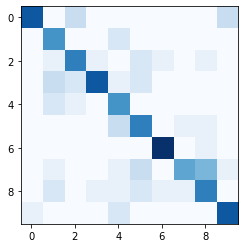

In [ ]:
# Test
y_pred = clf.predict(X_test)

# Classificaiton report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

Il valore dell'accuracy è aumentato fino a 0.64. Il modello è migliorato notevolmente rispetto a prima. 
Implemetando ulteriori features e lavorando con altri classificatori si potrebbe forse giungere a risultati migliori.